# PREPROCESSING
- Load the data
- Feature extraction
- Text cleaning
- Convert to matrix

This is applied on the entire dataset.

In [1]:
rm(list=ls())

# Variables
Main variables are organised here for the ease of edit

In [2]:
DTM_SPARSITY <- 0.99985

ACTIVATE_CHAR_STRING <- TRUE
CHAR_STRING <- "\"!#$%&',./|~(){}[]*?+-:;<=>^_`"
# CHAR_STRING <- "\"!#$%&',./0123456789:;<=>@ABCDEFGHIJKLMNOPQRSTUVWXYZ^_`abcdefghijklmnopqrstuvwxyz|~(){}[]*?+-"

ACTIVATE_PHARSE_LIST <- TRUE
PHARSE_LIST <- c(
     "{link}", ":)","&lt;3", "@mention", ":D", ":("
)

# random forest
RF_NODESIZE <- 1
RF_NTREE    <- 500

# Load Data

In [3]:
library(tictoc) # to measure time taken to execute

In [4]:
train <- read.csv("../input/2019tae/train.csv")
test <- read.csv("../input/2019tae/test.csv")
train <- train[sample(nrow(train)),]  # shuffle training set for good measure

In [5]:
library(plyr)
combined <- rbind.fill(train, test)
combined[22495:22505,]

,tweet,sentiment,Id
,<fct>,<int>,<int>
22495,"Statesville, NC Weather - 10:00 AM- Fair Skies, Temp: 69.4, Wind: 1.4, Rain Today: 0.00",2,NA
22496,Wtf its raining?!!! I need a cuddle boo in this crazy weather :-/,1,NA
22497,@mention Haa thanks:) yeh I'm fine thanks enjoying the lovely hot sun over here:) what's the weather like in England? X,3,NA
22498,#WEATHER: 6:52 am : 62.0F. Feels F. 29.76% Humidity. 0.0MPH North Wind.,2,NA
22499,Fuck this weather duude,1,NA
22500,Storm center in Norman predicting up to golf ball-sized hail in #stwok with winds gusting up to 60 mph. Warning through 4:45 pm,2,NA
22501,#WEATHER: 2:55 pm : 93.0F. Feels F. 29.92% Humidity. 10.4MPH Southwest Wind.,NA,1
22502,RT @mention: We are looking forward to dinner with the @mention folks on Sat...weather looks awesome! #GleekRetreat11 &lt;&lt; excited!,NA,2
22503,"The grill is hot, BBQ chicken is cookin', beer in hand, beautiful weather, and the boys enjoying their play set. #goodtimes",NA,3


Observe a random sample

In [6]:
combined[sample(nrow(combined), 20),]

,tweet,sentiment,Id
,<fct>,<int>,<int>
20428,RT @mention: Severe weather today will stay in eastern Okla... {link},2,NA
28636,Storm clouds moving in. It's time to fire up Motion Pics app to capture a time lapse video. My past attempt {link},NA,6136
23000,@mention hope u play today :) shame about the weather,NA,500
8223,My butt cheeks are going to fall of they are so cold. I hate when its cold and rainy and im stuck outside,1,NA
7198,Woke up to the sound of a thunderstorm and hail this morning.,2,NA
26624,Wtf what happened to the gorgeous weather,NA,4124
26490,"Probably just crappy here, could be sunny there. RT @mention: @mention @mention @mention it's not too bad, we will have fun!!",NA,3990
16736,Waiting for my best pal to come pick me up for a ride in her convertible MiniCooper. Windy as all get out here in MN. This could go badly.,1,NA
8946,Shorty do look like the weather outside today tho.....#Nice,3,NA


# Feature extraction

Character counts. List of characters to watch is in the hyper parameter.

In [7]:
library(stringr)

if (!ACTIVATE_CHAR_STRING){CHAR_STRING <- "!"}
charString_split <- strsplit(CHAR_STRING, "")[[1]]

for (i in 1:length(charString_split)) {
    combined$placeholder_name <- str_count(combined$tweet, fixed(charString_split[[i]]))
    names(combined)[names(combined) == "placeholder_name"] <- paste("char_", i, sep="")
}

Phrase counts. List of phrases to watch is in the hyper parameter.

In [8]:
if (!ACTIVATE_PHARSE_LIST){PHARSE_LIST <- c("@mention", "{link}")}

for (i in 1:length(PHARSE_LIST)) {
    combined$placeholder_name <- str_count(combined$tweet, fixed(PHARSE_LIST[[i]]))
    names(combined)[names(combined) == "placeholder_name"] <- paste("phrase_", i, sep="")
}

We track the different character classes as well.

In [9]:
combined$alphacount  <- as.numeric(ldply(str_match_all(combined$tweet,"[A-Za-z]"),length)$V1)
combined$uppercount  <- as.numeric(ldply(str_match_all(combined$tweet,"[A-Z]"),length)$V1)
combined$lowercount  <- as.numeric(ldply(str_match_all(combined$tweet,"[a-z]"),length)$V1)
combined$numbercount <- as.numeric(ldply(str_match_all(combined$tweet,"[0-9]"),length)$V1)
combined$propercount <- as.numeric(ldply(str_match_all(combined$tweet," [A-Z]"),length)$V1)
combined$length      <- as.numeric(ldply(str_match_all(combined$tweet,"(.*?)"),length)$V1)

combined$aftercaps   <- combined$uppercount - combined$propercount
combined$updowndiff  <- combined$uppercount - combined$lowercount

combined$alpharatio  <- combined$alphacount/combined$length
combined$numsratio   <- combined$numbercount/combined$length
combined$capsratio   <- combined$uppercount/combined$alphacount
combined$aftcp_ratio <- combined$aftercaps/combined$length

library(rebus.base)
vowels <- char_class("aeiouAEIOU")
not_vowels <- negated_char_class("aeiouAEIOU")
combined$repeatvowels <-as.numeric(ldply(str_match_all(combined$tweet,pattern= one_or_more(vowels)),length)$V1)
combined$repeatnonvowels <-as.numeric(ldply(str_match_all(combined$tweet,pattern= one_or_more(not_vowels)),length)$V1)

combined <- within(combined, rm(alphacount, uppercount, lowercount, 
                                numbercount, propercount, aftercaps))


Attaching package: ‘rebus.base’


The following object is masked from ‘package:stringr’:

    regex




In [10]:
combined[sample(nrow(combined), 5),]

,tweet,sentiment,Id,char_1,char_2,char_3,char_4,char_5,char_6,char_7,⋯,phrase_5,phrase_6,length,updowndiff,alpharatio,numsratio,capsratio,aftcp_ratio,repeatvowels,repeatnonvowels
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3377,"Anthem, AZ @mention:00 PM, Temp:71.6&#xB0;F, Wind:0.0 mph NNE, Baro:29.42 inches, Hum: 25, Rain:0.00 in., Hi:92.8&#xB0;F, Lo:63.0&#xB0;F@mention:09 AM",2,NA,0,0,3,0,0,3,0,⋯,0,0,302,-26,0.2384106,0.089403974,0.31944444,0.039735099,20,20
27978,This weekend has gone by way too fast. The best part though is 3 straight days of good golfing weather.,NA,5478,0,0,0,0,0,0,0,⋯,0,0,210,-77,0.3857143,0.004761905,0.02469136,0.004761905,22,23
5482,At 11- Very interesting thunderstorm complex racing across Gulf of Mexico tonight. Straight ahead I'll tell you if it will head out way!,2,NA,0,1,0,0,0,0,1,⋯,0,0,274,-96,0.3941606,0.007299270,0.05555556,0.003649635,34,34
16843,"great weather, chilling on my deck. Nice view {link}",3,NA,0,0,0,0,0,0,0,⋯,0,0,106,-38,0.3773585,0.000000000,0.02500000,0.000000000,11,12
20841,#WEATHER: 3:18 am E: 56.3F. Feels F. % Humidity. 1.1MPH East Wind.,2,NA,0,0,1,0,1,0,0,⋯,0,0,134,-2,0.2686567,0.059701493,0.47222222,0.082089552,10,11


# Text cleaning

In [11]:
library(tm)
corpus <- Corpus(VectorSource(combined$tweet))
getTransformations()

Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:httr’:

    content




[1] "removeNumbers"     "removePunctuation" "removeWords"      
[4] "stemDocument"      "stripWhitespace"

In [12]:
tic()
corpus <- tm_map(corpus, function(x) iconv(enc2utf8(x), sub = "byte"))
corpus <- tm_map(corpus, content_transformer(function(x) iconv(enc2utf8(x), sub = "bytes")))
corpus <- tm_map(corpus,content_transformer(tolower))
corpus <- tm_map(corpus,removeWords,stopwords("english"))
corpus <- tm_map(corpus,removeWords,c("xkcd, make, get, well, goodbye"))
corpus <- tm_map(corpus,removePunctuation)
toc()

Warning message in tm_map.SimpleCorpus(corpus, function(x) iconv(enc2utf8(x), sub = "byte")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, content_transformer(function(x) iconv(enc2utf8(x), :
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("english")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, c("xkcd, make, get, well, goodbye")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
“transformation drops documents”


0.358 sec elapsed


# Text to matrix

In [13]:
library(SnowballC)
corpus <- tm_map(corpus,stemDocument)

Warning message in tm_map.SimpleCorpus(corpus, stemDocument):
“transformation drops documents”


In [14]:
dtm <- DocumentTermMatrix(corpus)

In [15]:
dtm <- removeSparseTerms(dtm, DTM_SPARSITY)
sparse <- as.data.frame(as.matrix(dtm))
colnames(sparse) <- make.names(colnames(sparse))

In [16]:
library(dplyr)
combined_features <- within(combined, rm(tweet, Id))
sparse <- bind_cols(combined_features, sparse)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [17]:
# write.csv(sparse, "the_dataset.csv", row.names=FALSE)
# sparse[1:10,]

# MODEL EXPERIMENTATION

In [18]:
tic()
library(randomForest)
model <- randomForest(as.factor(sentiment)~.,data=sparse[1:22500,], 
                      ntree=RF_NTREE, nodesize=RF_NODESIZE)
summary(model)
toc()

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine




                Length Class  Mode     
call                5  -none- call     
type                1  -none- character
predicted       22500  factor numeric  
err.rate         2000  -none- numeric  
confusion          12  -none- numeric  
votes           67500  matrix numeric  
oob.times       22500  -none- numeric  
classes             3  -none- character
importance       3814  -none- numeric  
importanceSD        0  -none- NULL     
localImportance     0  -none- NULL     
proximity           0  -none- NULL     
ntree               1  -none- numeric  
mtry                1  -none- numeric  
forest             14  -none- list     
y               22500  factor numeric  
test                0  -none- NULL     
inbag               0  -none- NULL     
terms               3  terms  call     

30086.662 sec elapsed


# Model analysis
We analyse the characteristics of the model.

In [19]:
model$confusion
training_accuracy = sum(diag(model$confusion))/length(trn_idx)
training_accuracy

,1,2,3,class.error
1,5832,340,780,0.1611047
2,1042,6564,355,0.1754805
3,791,183,6613,0.1283775


ERROR: Error in eval(expr, envir, enclos): object 'trn_idx' not found


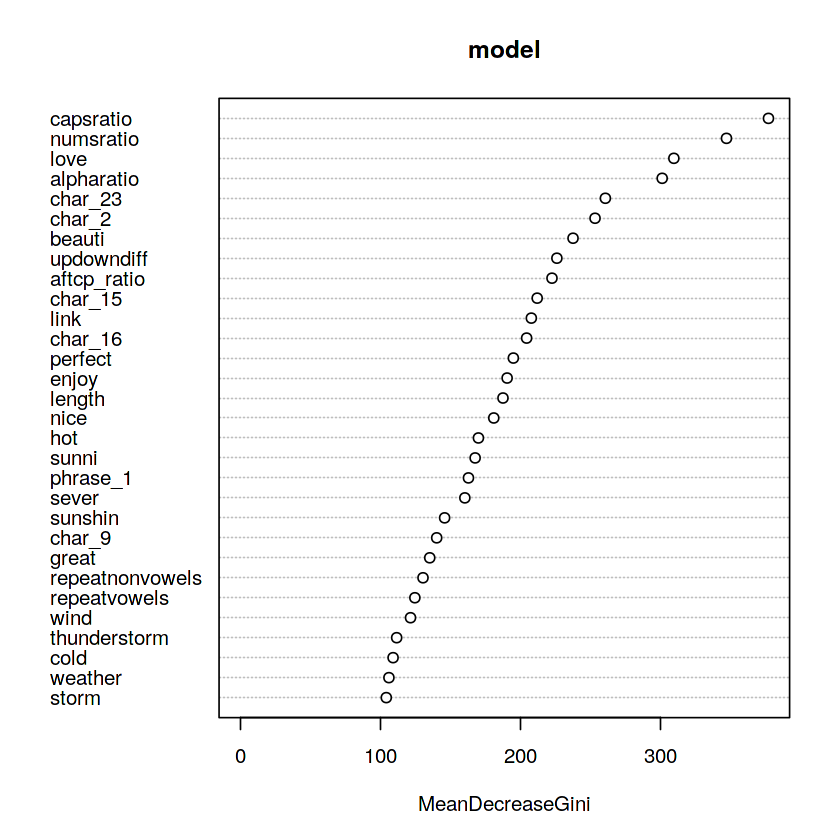

In [20]:
varImpPlot(model)

# Prediction on the test set

In [21]:
pred_test <- predict(model,newdata=sparse[22501:30000,],type="prob")
pred_test_matrix <- pred_test

In [22]:
pred_test_class <- c()

for (i in 1:nrow(pred_test_matrix)){
    class_with_max_prob <- names(pred_test_matrix[i,][pred_test_matrix[i,] == max(pred_test_matrix[i,])])[[1]]
    pred_test_class <- append(pred_test_class, class_with_max_prob)
    if (length(pred_test_class) != i){print(i)}
}

In [23]:
test$sentiment <- pred_test_class
test[sample(nrow(test), 20), ]

,Id,tweet,sentiment
,<int>,<fct>,<chr>
5601,5601,SUNSHINE SUNSHINE SUNSHINE,3
5030,5030,A cute family on this rainy dreary day. Working on their gallery. And about 10 other things :) {link},3
5594,5594,#WEATHER: 11:54 am: 79.9F. Feels F. % Humidity. 3.3MPH East Wind.,2
3249,3249,Loves working Outside in this Weather,3
7256,7256,"RT @mention: ""The art of knowing is knowing what to ignore."" Rumi #WuWednesday Enjoy the sunshine today, Wu-Disciples! Peace!",3
1798,1798,"weather.com update: Current Weather Conditions In Las Vegas, NV (89119) {link}",2
5150,5150,"Dear Thunderstorms, please go away so my 3 shows will come on tonight! plus i hate storms haha..sincerly, devoted idol, glee. #thevioce fan",1
308,308,I need to go back to #Miami....this weather and this place is draining the life out of me.,1
1575,1575,"Severe Thunderstorm Warning for Comanche, Hamilton, and Mills County in TX until 9:00am CDT. #txwx",2


In [24]:
test <- subset(test, select=c("Id", "sentiment"))
write.csv(test, "submission.csv", row.names=FALSE)

In [25]:
table(test$sentiment)


   1    2    3 
2588 2342 2570 